# Microbleed Label Segmentation - Synthetic Data
  

## Setup and Imports


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation

Mounted at /content/drive
/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation


In [2]:
!pip install -r Microbleed_Segmentation/requirements.txt

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/src')

from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    RandSpatialCrop,
    Spacingd,
    ToTensord,
    NormalizeIntensityd,
    RandAffined,
    ResizeWithPadOrCropd,
    RandWeightedCropd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandZoomd,
    RandSpatialCropd,
    SpatialCropd
)
from sampling import RandUniformSamplingCropd
from monai.networks.nets import UNet, BasicUNet
from monai.networks.layers import Norm
from monai.metrics import compute_meandice
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.data.utils import pad_list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract
import numpy as np
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import monai  

import math

import pandas as pd
import nibabel as nb

from Transforms import *

from UNet import UNet

import timeit
from torch.optim.lr_scheduler import ReduceLROnPlateau

from typing import Any, Callable, Dict, Hashable, List, Mapping

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Helper Functions

In [4]:
# Helper functions
class DataDict():
    Image = 'image'
    ImageHelper = 'image_helper' #image.zeros with coordinates marked with 1s to help network locate region to mark
    Label = 'label'
    FileName = 'filename'
    ID = 'id'
    VersionId = 'version_id'
    ScanTimeVersion = 'scan_time_version'
    X = 'x'
    Y = 'y'
    Z = 'z'

class SpatialCropd(SpatialCropd):
    def __call__(self, data: Mapping[Hashable, np.ndarray]) -> Dict[Hashable, np.ndarray]:
        d = dict(data)
        # print(len(d))
        for key in self.key_iterator(d):
            self.push_transform(d, key)
            print(f"key is {key}")
            print(f"shape is {d[key].shape}")
            print(f"self cropper coord {self.cropper.roi_center}")
            d[key] = self.cropper(d[key])
            print(f"shape after is {d[key].shape}")
        return d

class ImagesToMultiChannel(MapTransform):
    def __call__(self, data):
        to_concat_list = []
        for key in self.keys:
            to_concat_list.append(data[key])
            
        data[DataDict.Image] = torch.cat(to_concat_list, dim=0)
        return data

def get_swi_subject_id(file_name, ext='.nii.gz'):
    return int(file_name.split("EPAD")[-1].replace(ext, "").replace("_swi", "").replace("_cmb_seg", ""))

def get_subject_id_from_image_label(path1, path2):
    path1_id = get_swi_subject_id(path1)
    path2_id = get_swi_subject_id(path2)

    if not path1_id == path2_id:
        raise ValueError("Subject mismatch")

    return path1_id


# Convert torch tensor to numpy array
def numpy_from_tensor(x):
  return x.detach().cpu().numpy()

# Predefined checkpoint dictionary
class CheckpointDict():
    EPOCH = 'epoch'
    MODEL_STATE_DICT = 'model_state_dict'
    OPTIMIZER_STATE_DICT = 'optimizer_state_dict'
    LOSS = 'loss'
    LOSSES = 'losses'
    VALIDATION_LOSSES = 'val_losses'


def display_losses(checkpoint, title='Network Losses', x_label='Epoch', y_label='Loss', combine_train_val=True):
    train_losses, val_losses = get_checkpoint_losses(checkpoint)

    val_losses = dict_tensor_to_cpu(val_losses)
    val_tensors = dict_tensor_to_value(val_losses)

    training_losses = sorted(train_losses.items())  # sorted by key, return a list of tuples
    x, y = zip(*training_losses)  # unpack a list of pairs into two tuples
    validation_losses = sorted(val_tensors.items())
    x2, y2 = zip(*validation_losses)  # unpack a list of pairs into two tuples

    if combine_train_val:
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.plot(x, y, label="Training")
        plt.plot(x2, y2, label="Validation")
        plt.legend()
        plt.show()
    else:
        fig, axs = plt.subplots(2, 1, constrained_layout=True)
        fig.suptitle(title, fontsize=16)

        axs[0].plot(x, y)
        axs[0].set_title('Training Losses')
        axs[0].set_xlabel(x_label)
        axs[0].set_ylabel(y_label)

        axs[1].plot(x2, y2, color='r')
        axs[1].set_title('Validation Losses')
        axs[1].set_xlabel(x_label)
        axs[1].set_ylabel(y_label)

        plt.show()

def get_checkpoint_losses(checkpoint):
    losses = checkpoint[CheckpointDict.LOSSES]
    val_losses = checkpoint[CheckpointDict.VALIDATION_LOSSES]
    val_losses = dict_tensor_to_cpu(val_losses)
    val_tensors = dict_tensor_to_value(val_losses)
    return losses, val_losses

def get_checkpoint_model_state_dict(checkpoint):
    return checkpoint[CheckpointDict.MODEL_STATE_DICT]


def dict_tensor_to_cpu(dict_tensors):
    for key in dict_tensors.keys():
        dict_tensors[key] = tensor_to_cpu(dict_tensors[key])

    return dict_tensors


def tensor_to_cpu(x):
    return x.detach().cpu()


def dict_tensor_to_value(dicts):
    if next(iter(dicts)) is not type(torch.tensor):
        return dicts

    for keys in dicts:
        dicts[keys] = dicts[keys].item()

    return dicts


# Get dictionarys from a list_dict filtered by a spcific key value
def get_dicts_from_dicts(dicts, key, value):
    x = [item for item in dicts if item[key] == value]
    return x


post_pred = AsDiscrete(n_classes=2, threshold_values=True)
post_label = AsDiscrete(to_onehot=True, n_classes=2)

## Coordinates Dataframe

### Real Microbleed DataFrame

In [5]:
# Get Coordinates for labels
coord_file_path_real = "/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/rCMBInformationInfo.xlsx"


coordinate_info_real_microbleed_df = pd.read_excel(coord_file_path_real)
N = 52
coordinate_info_real_microbleed_df  = coordinate_info_real_microbleed_df.iloc[: , :N]
# coordinate_info_real_microbleed_df

In [6]:
coordinate_info_real_microbleed_df.rename(columns={"Location CMB # 1": "11-1", "Unnamed: 2": "11-2", "Unnamed: 3": "11-3",
                   "Location CMB # 2": "12-1", "Unnamed: 5": "12-2", "Unnamed: 6": "12-3",
                   "Location CMB # 3": "13-1", "Unnamed: 8": "13-2", "Unnamed: 9": "13-3",
                   "Location CMB # 4": "14-1", "Unnamed: 11": "14-2", "Unnamed: 12": "14-3",
                   "Location CMB # 5": "15-1", "Unnamed: 14": "15-2", "Unnamed: 15": "15-3",
                   "Location CMB # 6": "16-1", "Unnamed: 17": "16-2", "Unnamed: 18": "16-3",
                   "Location CMB # 7": "17-1", "Unnamed: 20": "17-2", "Unnamed: 21": "17-3",
                   "Location CMB # 8": "18-1", "Unnamed: 23": "18-2", "Unnamed: 24": "18-3",
                   "Location CMB # 9": "19-1", "Unnamed: 26": "19-2", "Unnamed: 27": "19-3",
                   "Location CMB # 10": "20-1", "Unnamed: 29": "20-2", "Unnamed: 30": "20-3",
                   "Location CMB # 11": "21-1", "Unnamed: 32": "21-2", "Unnamed: 33": "21-3",
                   "Location CMB # 12": "22-1", "Unnamed: 35": "22-2", "Unnamed: 36": "22-3",
                   "Location CMB # 13": "23-1", "Unnamed: 38": "23-2", "Unnamed: 39": "23-3",
                   "Location CMB # 14": "24-1", "Unnamed: 41": "24-2", "Unnamed: 42": "24-3",
                   "Location CMB # 15": "25-1", "Unnamed: 44": "25-2", "Unnamed: 45": "25-3",
                   "Location CMB # 16": "26-1", "Unnamed: 47": "26-2", "Unnamed: 48": "26-3",
                   "Location CMB # 17": "27-1", "Unnamed: 50": "27-2", "Unnamed: 51": "27-3",
                   }, inplace=True)

coordinate_info_real_microbleed_df

,NIFTI File Name,11-1,11-2,11-3,12-1,12-2,12-3,13-1,13-2,13-3,14-1,14-2,14-3,15-1,15-2,15-3,16-1,16-2,16-3,17-1,17-2,17-3,18-1,18-2,18-3,19-1,19-2,19-3,20-1,20-2,20-3,21-1,21-2,21-3,22-1,22-2,22-3,23-1,23-2,23-3,24-1,24-2,24-3,25-1,25-2,25-3,26-1,26-2,26-3,27-1,27-2,27-3
0,122_T1_MRI_SWI_BFC_50mm_HM.nii.gz,64,175,12,125,134,44,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,122_T2_MRI_SWI_BFC_50mm_HM.nii.gz,51,167,26,65,171,13,132,102,39,131,123,43,126,129,45,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,218_T0_MRI_SWI_BFC_50mm_HM.nii.gz,74,175,13,143,150,56,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,218_T2_MRI_SWI_BFC_50mm_HM.nii.gz,75,177,14,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,218_T3_MRI_SWI_BFC_50mm_HM.nii.gz,71,178,16,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,219_T0_MRI_SWI_BFC_50mm_HM.nii.gz,119,112,42,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,221_T2_MRI_SWI_BFC_50mm_HM.nii.gz,137,143,22,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,222_T0_MRI_SWI_BFC_50mm_HM.nii.gz,149,164,37,89,86,60,97,62,58,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,222_T1_MRI_SWI_BFC_50mm_HM.nii.gz,67,219,32,93,76,64,86,100,65,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,238_T0_MRI_SWI_BFC_50mm_HM.nii.gz,65,176,6,122,173,7,128,204,31,112,82,49,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### Synthetic Microbleed DataFrame

In [7]:
# Get Coordinates for labels - Synthetic
coord_file_path_synthetic = "/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMBInformationInfo.xlsx"


coordinate_info_synthetic_microbleed_df = pd.read_excel(coord_file_path_synthetic)
N = 31
coordinate_info_synthetic_microbleed_df  = coordinate_info_synthetic_microbleed_df.iloc[: , :N]
coordinate_info_synthetic_microbleed_df

,NIFTI File Name,Location CMB #1,Unnamed: 2,Unnamed: 3,Location CMB #2,Unnamed: 5,Unnamed: 6,Location CMB #3,Unnamed: 8,Unnamed: 9,Location CMB #4,Unnamed: 11,Unnamed: 12,Location CMB #5,Unnamed: 14,Unnamed: 15,Location CMB #6,Unnamed: 17,Unnamed: 18,Location CMB #7,Unnamed: 20,Unnamed: 21,Location CMB #8,Unnamed: 23,Unnamed: 24,Location CMB #9,Unnamed: 26,Unnamed: 27,Location CMB #10,Unnamed: 29,Unnamed: 30
0,122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V1.nii.gz,103,64,46,35,151,46,46,130,30,34,161,40,38,116,27,57,202,28,56,141,63,100,80,63,97,161,64,121,183,20
1,122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V2.nii.gz,140,116,28,118,196,31,97,161,64,53,172,11,60,190,23,69,72,42,98,145,19,64,154,23,144,166,54,147,144,48
2,122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3.nii.gz,83,87,65,123,87,36,58,181,60,93,114,64,39,108,32,49,86,44,125,171,14,149,153,41,83,87,65,59,198,28
3,122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V4.nii.gz,42,153,61,123,87,36,56,141,63,72,174,71,57,202,28,73,188,18,154,156,40,82,196,24,97,137,64,123,87,36
4,122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V5.nii.gz,61,143,35,89,207,33,93,129,68,77,200,57,112,178,67,143,196,48,127,175,8,151,180,42,42,153,61,49,86,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,316_T0_MRI_SWI_BFC_50mm_HM_rsCMB_V6.nii.gz,129,109,56,47,186,27,98,61,44,88,135,24,114,197,16,59,201,22,130,169,52,32,139,34,111,108,33,72,182,12
566,316_T0_MRI_SWI_BFC_50mm_HM_rsCMB_V7.nii.gz,106,129,29,49,124,59,75,201,54,44,173,24,31,131,37,130,169,52,47,202,32,57,156,25,102,143,20,79,155,14
567,316_T0_MRI_SWI_BFC_50mm_HM_rsCMB_V8.nii.gz,44,158,57,49,124,59,128,175,25,123,135,32,62,106,37,59,81,46,145,163,41,47,148,32,145,166,44,62,150,24
568,316_T0_MRI_SWI_BFC_50mm_HM_rsCMB_V9.nii.gz,50,197,34,97,199,23,111,108,33,47,202,32,120,157,29,123,110,59,80,131,66,106,129,29,87,168,11,126,160,17


In [8]:
coordinate_info_synthetic_microbleed_df.rename(columns={"Location CMB #1": "1-1", "Unnamed: 2": "1-2", "Unnamed: 3": "1-3",
                   "Location CMB #2": "2-1", "Unnamed: 5": "2-2", "Unnamed: 6": "2-3",
                   "Location CMB #3": "3-1", "Unnamed: 8": "3-2", "Unnamed: 9": "3-3",
                   "Location CMB #4": "4-1", "Unnamed: 11": "4-2", "Unnamed: 12": "4-3",
                   "Location CMB #5": "5-1", "Unnamed: 14": "5-2", "Unnamed: 15": "5-3",
                   "Location CMB #6": "6-1", "Unnamed: 17": "6-2", "Unnamed: 18": "6-3",
                   "Location CMB #7": "7-1", "Unnamed: 20": "7-2", "Unnamed: 21": "7-3",
                   "Location CMB #8": "8-1", "Unnamed: 23": "8-2", "Unnamed: 24": "8-3",
                   "Location CMB #9": "9-1", "Unnamed: 26": "9-2", "Unnamed: 27": "9-3",
                   "Location CMB #10": "10-1", "Unnamed: 29": "10-2", "Unnamed: 30": "10-3"
                   }, inplace=True)

coordinate_info_synthetic_microbleed_df

,NIFTI File Name,1-1,1-2,1-3,2-1,2-2,2-3,3-1,3-2,3-3,4-1,4-2,4-3,5-1,5-2,5-3,6-1,6-2,6-3,7-1,7-2,7-3,8-1,8-2,8-3,9-1,9-2,9-3,10-1,10-2,10-3
0,122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V1.nii.gz,103,64,46,35,151,46,46,130,30,34,161,40,38,116,27,57,202,28,56,141,63,100,80,63,97,161,64,121,183,20
1,122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V2.nii.gz,140,116,28,118,196,31,97,161,64,53,172,11,60,190,23,69,72,42,98,145,19,64,154,23,144,166,54,147,144,48
2,122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3.nii.gz,83,87,65,123,87,36,58,181,60,93,114,64,39,108,32,49,86,44,125,171,14,149,153,41,83,87,65,59,198,28
3,122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V4.nii.gz,42,153,61,123,87,36,56,141,63,72,174,71,57,202,28,73,188,18,154,156,40,82,196,24,97,137,64,123,87,36
4,122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V5.nii.gz,61,143,35,89,207,33,93,129,68,77,200,57,112,178,67,143,196,48,127,175,8,151,180,42,42,153,61,49,86,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,316_T0_MRI_SWI_BFC_50mm_HM_rsCMB_V6.nii.gz,129,109,56,47,186,27,98,61,44,88,135,24,114,197,16,59,201,22,130,169,52,32,139,34,111,108,33,72,182,12
566,316_T0_MRI_SWI_BFC_50mm_HM_rsCMB_V7.nii.gz,106,129,29,49,124,59,75,201,54,44,173,24,31,131,37,130,169,52,47,202,32,57,156,25,102,143,20,79,155,14
567,316_T0_MRI_SWI_BFC_50mm_HM_rsCMB_V8.nii.gz,44,158,57,49,124,59,128,175,25,123,135,32,62,106,37,59,81,46,145,163,41,47,148,32,145,166,44,62,150,24
568,316_T0_MRI_SWI_BFC_50mm_HM_rsCMB_V9.nii.gz,50,197,34,97,199,23,111,108,33,47,202,32,120,157,29,123,110,59,80,131,66,106,129,29,87,168,11,126,160,17


### Combine into one dataframe

In [9]:
# Create matching column names to merge (real and synthetic titled slightly differently)
repeat_count = 20
# Duplicate 20 times over row to ensure all versions (check synthetic) are included
coordinate_info_real_microbleed_formatted_df = pd.concat([coordinate_info_real_microbleed_df]*repeat_count, ignore_index=True)

# Group common rows together and reset index
coordinate_info_real_microbleed_formatted_df.sort_values(by='NIFTI File Name', inplace=True)
coordinate_info_real_microbleed_formatted_df.reset_index(inplace=True)

coordinate_info_real_microbleed_formatted_df

,index,NIFTI File Name,11-1,11-2,11-3,12-1,12-2,12-3,13-1,13-2,13-3,14-1,14-2,14-3,15-1,15-2,15-3,16-1,16-2,16-3,17-1,17-2,17-3,18-1,18-2,18-3,19-1,19-2,19-3,20-1,20-2,20-3,21-1,21-2,21-3,22-1,22-2,22-3,23-1,23-2,23-3,24-1,24-2,24-3,25-1,25-2,25-3,26-1,26-2,26-3,27-1,27-2,27-3
0,0,122_T1_MRI_SWI_BFC_50mm_HM.nii.gz,64,175,12,125,134,44,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,57,122_T1_MRI_SWI_BFC_50mm_HM.nii.gz,64,175,12,125,134,44,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,969,122_T1_MRI_SWI_BFC_50mm_HM.nii.gz,64,175,12,125,134,44,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,912,122_T1_MRI_SWI_BFC_50mm_HM.nii.gz,64,175,12,125,134,44,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,114,122_T1_MRI_SWI_BFC_50mm_HM.nii.gz,64,175,12,125,134,44,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,900,3_T2_MRI_SWI_BFC_50mm_HM.nii.gz,77,173,55,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1136,957,3_T2_MRI_SWI_BFC_50mm_HM.nii.gz,77,173,55,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1137,1014,3_T2_MRI_SWI_BFC_50mm_HM.nii.gz,77,173,55,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1138,330,3_T2_MRI_SWI_BFC_50mm_HM.nii.gz,77,173,55,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [10]:
# Rename header name to match synthetic data type
for i, row in coordinate_info_real_microbleed_formatted_df.iterrows():
    version = i % repeat_count + 1

    to_replace = row['NIFTI File Name']
    to_replace = to_replace.replace("_HM.nii.gz", f"_HM_rsCMB_V{str(version)}.nii.gz")

    coordinate_info_real_microbleed_formatted_df.at[i, 'NIFTI File Name'] = to_replace

In [11]:
# Merge synthetic and real data together into one pandas
coordinate_info_df = coordinate_info_synthetic_microbleed_df.merge(coordinate_info_real_microbleed_formatted_df, how = 'inner', on='NIFTI File Name').drop_duplicates()
coordinate_info_df = coordinate_info_df.drop(['index'], axis=1)
coordinate_info_df

,NIFTI File Name,1-1,1-2,1-3,2-1,2-2,2-3,3-1,3-2,3-3,4-1,4-2,4-3,5-1,5-2,5-3,6-1,6-2,6-3,7-1,7-2,7-3,8-1,8-2,8-3,9-1,9-2,9-3,10-1,10-2,10-3,11-1,11-2,11-3,12-1,12-2,12-3,13-1,13-2,13-3,...,14-3,15-1,15-2,15-3,16-1,16-2,16-3,17-1,17-2,17-3,18-1,18-2,18-3,19-1,19-2,19-3,20-1,20-2,20-3,21-1,21-2,21-3,22-1,22-2,22-3,23-1,23-2,23-3,24-1,24-2,24-3,25-1,25-2,25-3,26-1,26-2,26-3,27-1,27-2,27-3
0,122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V1.nii.gz,103,64,46,35,151,46,46,130,30,34,161,40,38,116,27,57,202,28,56,141,63,100,80,63,97,161,64,121,183,20,64,175,12,125,134,44,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V2.nii.gz,140,116,28,118,196,31,97,161,64,53,172,11,60,190,23,69,72,42,98,145,19,64,154,23,144,166,54,147,144,48,64,175,12,125,134,44,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3.nii.gz,83,87,65,123,87,36,58,181,60,93,114,64,39,108,32,49,86,44,125,171,14,149,153,41,83,87,65,59,198,28,64,175,12,125,134,44,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V4.nii.gz,42,153,61,123,87,36,56,141,63,72,174,71,57,202,28,73,188,18,154,156,40,82,196,24,97,137,64,123,87,36,64,175,12,125,134,44,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V5.nii.gz,61,143,35,89,207,33,93,129,68,77,200,57,112,178,67,143,196,48,127,175,8,151,180,42,42,153,61,49,86,44,64,175,12,125,134,44,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,316_T0_MRI_SWI_BFC_50mm_HM_rsCMB_V6.nii.gz,129,109,56,47,186,27,98,61,44,88,135,24,114,197,16,59,201,22,130,169,52,32,139,34,111,108,33,72,182,12,126,203,43,98,225,34,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
566,316_T0_MRI_SWI_BFC_50mm_HM_rsCMB_V7.nii.gz,106,129,29,49,124,59,75,201,54,44,173,24,31,131,37,130,169,52,47,202,32,57,156,25,102,143,20,79,155,14,126,203,43,98,225,34,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
567,316_T0_MRI_SWI_BFC_50mm_HM_rsCMB_V8.nii.gz,44,158,57,49,124,59,128,175,25,123,135,32,62,106,37,59,81,46,145,163,41,47,148,32,145,166,44,62,150,24,126,203,43,98,225,34,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
568,316_T0_MRI_SWI_BFC_50mm_HM_rsCMB_V9.nii.gz,50,197,34,97,199,23,111,108,33,47,202,32,120,157,29,123,110,59,80,131,66,106,129,29,87,168,11,126,160,17,126,203,43,98,225,34,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Manually Annotated Labels - For trainining to predict and obtain other labels

In [12]:
training_labels_data_path = "/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/Labels"

train_labels = sorted(glob.glob(os.path.join(training_labels_data_path, "*.nii.gz")))
train_labels

['/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/Labels/122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3_Label.nii.gz',
 '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/Labels/257_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V1_Label.nii.gz',
 '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/Labels/260_T2_MRI_SWI_BFC_50mm_HM_rsCMB_V6_Label.nii.gz',
 '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/Labels/275_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V2_Label.nii.g

In [13]:
train_images = [label.replace("Labels/", "").replace("_Label.nii.gz", ".nii.gz") for label in train_labels]
train_images

['/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3.nii.gz',
 '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/257_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V1.nii.gz',
 '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/260_T2_MRI_SWI_BFC_50mm_HM_rsCMB_V6.nii.gz',
 '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/275_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V2.nii.gz',
 '/content/drive/MyDrive/Brain Health In COVID 1

In [14]:
train_data_paths = []
for i in range(len(train_labels)):
    train_data_paths.append({DataDict.FileName: train_images[i].split("/")[-1], DataDict.Image: train_images[i], DataDict.Label: train_labels[i]})
train_data_paths

[{'filename': '122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3.nii.gz',
  'image': '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3.nii.gz',
  'label': '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/Labels/122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3_Label.nii.gz'},
 {'filename': '257_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V1.nii.gz',
  'image': '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/257_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V1.nii.gz',
  'label': '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-

In [37]:
data_dict = []

image_coordinate_guider_dir = "/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/GeneratedLabels/FakeGeneratedLabels/"

#Build coordinate system
for single_train_data in train_data_paths:
    target_df_row = coordinate_info_df.loc[coordinate_info_df['NIFTI File Name'] == single_train_data[DataDict.FileName]]
    
    # Get subject Id, T and V numbers to match exact file
    # E.g. "3_T2_MRI_SWI_BFC_50mm_HM_rsCMB_V1.nii.gz"
    subject_id = int(single_train_data[DataDict.FileName].split('_')[0])
    t_number = int(single_train_data[DataDict.FileName].split('_')[1].replace('T', ''))
    v_number = int(single_train_data[DataDict.FileName].split('_')[-1].replace('.nii.gz', '').replace('V', ''))

    microbleed_detecting_helper_image = os.path.join(image_coordinate_guider_dir, f"{subject_id}_T{t_number}_V{v_number}/fake_label_{single_train_data[DataDict.FileName]}")

    for i in range(27):
        x = target_df_row.iloc[0][f'{i+1}-1']
        y = target_df_row.iloc[0][f'{i+1}-2']
        z = target_df_row.iloc[0][f'{i+1}-3']

        if isinstance(x, str) or isinstance(y, str) or isinstance(z, str):
            continue

        dict_to_append = {DataDict.FileName: single_train_data[DataDict.FileName], 
                          DataDict.Image: single_train_data[DataDict.Image], 
                          DataDict.ImageHelper: microbleed_detecting_helper_image,
                          DataDict.Label: single_train_data[DataDict.Label],
                          DataDict.X: target_df_row.iloc[0][f'{i+1}-1'],
                          DataDict.Y: target_df_row.iloc[0][f'{i+1}-2'],
                          DataDict.Z: target_df_row.iloc[0][f'{i+1}-3']}

        data_dict.append(dict_to_append)

In [38]:
len(data_dict)

129

In [39]:
data_dict[0]

{'filename': '122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3.nii.gz',
 'image': '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3.nii.gz',
 'image_helper': '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/GeneratedLabels/FakeGeneratedLabels/122_T1_V3/fake_label_122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3.nii.gz',
 'label': '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/Labels/122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3_Label.nii.gz',
 'x': 83,
 'y': 87,
 'z': 65}

## Sample Data Testing

In [40]:
sample_data = data_dict[5]

sample_data_image = nb.load(sample_data[DataDict.Image]).get_fdata()
sample_data_image_helper = nb.load(sample_data[DataDict.ImageHelper]).get_fdata()
sample_data_label = nb.load(sample_data[DataDict.Label]).get_fdata()
sample_x = sample_data[DataDict.X]-1
sample_y = sample_data[DataDict.Y]-1
sample_z = sample_data[DataDict.Z]-1

coordinate_tuple = (sample_data[DataDict.X], sample_data[DataDict.Y], sample_data[DataDict.Z])

print(f"image shape: {sample_data_image.shape}\nimage helper shape: {sample_data_image_helper.shape}\nlabel shape: {sample_data_label.shape}")

image shape: (176, 256, 80)
image helper shape: (176, 256, 80)
label shape: (176, 256, 80)


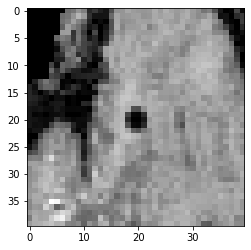

In [41]:
plt.imshow(sample_data_image[sample_x, sample_y-20:sample_y+20, sample_z-20:sample_z+20], cmap='gray')

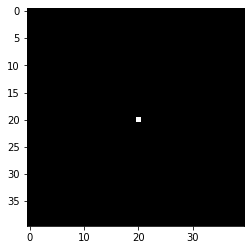

In [42]:
plt.imshow(sample_data_image_helper[sample_x, sample_y-20:sample_y+20, sample_z-20:sample_z+20], cmap='gray')

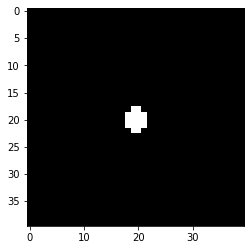

In [43]:
plt.imshow(sample_data_label[sample_x, sample_y-20:sample_y+20, sample_z-20:sample_z+20], cmap='gray')

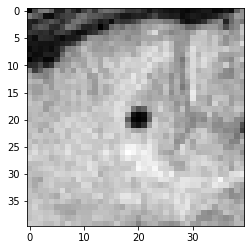

In [44]:
plt.imshow(sample_data_image[sample_x-20:sample_x+20, sample_y-20:sample_y+20, sample_z], cmap='gray')

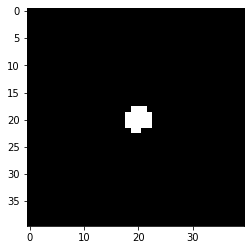

In [45]:
plt.imshow(sample_data_label[sample_x-20:sample_x+20, sample_y-20:sample_y+20, sample_z], cmap='gray')

In [46]:
sample_data_label.shape

(176, 256, 80)

In [47]:
sample_data

{'filename': '122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3.nii.gz',
 'image': '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3.nii.gz',
 'image_helper': '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/GeneratedLabels/FakeGeneratedLabels/122_T1_V3/fake_label_122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3.nii.gz',
 'label': '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/Labels/122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3_Label.nii.gz',
 'x': 49,
 'y': 86,
 'z': 44}

## Centre Coord Testing

In [48]:
test_centre = torch.zeros_like(torch.tensor(sample_data_label))
test_centre[sample_data[DataDict.X], sample_data[DataDict.Y], sample_data[DataDict.Z]] = 1

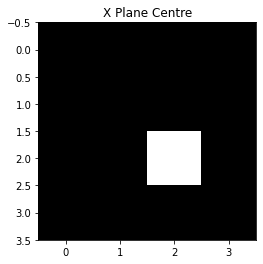

In [49]:
plt.title("X Plane Centre")
plt.imshow(test_centre[sample_data[DataDict.X], sample_data[DataDict.Y]-2:sample_data[DataDict.Y]+2, sample_data[DataDict.Z]-2:sample_data[DataDict.Z]+2], cmap='gray')

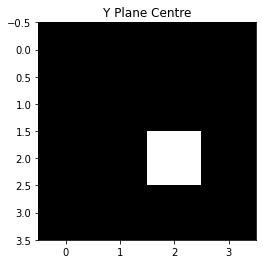

In [50]:
plt.title("Y Plane Centre")
plt.imshow(test_centre[sample_data[DataDict.X]-2:sample_data[DataDict.X]+2, sample_data[DataDict.Y], sample_data[DataDict.Z]-2:sample_data[DataDict.Z]+2], cmap='gray')

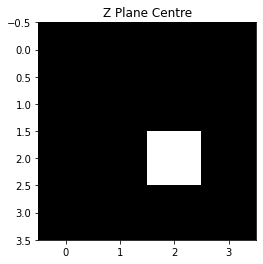

In [51]:
plt.title("Z Plane Centre")
plt.imshow(test_centre[sample_data[DataDict.X]-2:sample_data[DataDict.X]+2, sample_data[DataDict.Y]-2:sample_data[DataDict.Y]+2, sample_data[DataDict.Z]], cmap='gray')

## Transforms, Network and Dataset setup

In [52]:
# PATCH_SIZE = (32, 32, 32)
PATCH_SIZE = (16, 16, 16)


train_transforms = Compose(
    [
        LoadImaged(keys=[DataDict.Image, DataDict.ImageHelper, DataDict.Label]),
        AddChanneld(keys=[DataDict.Image, DataDict.ImageHelper, DataDict.Label]),
        ConvertToMultiChannelBasedOnLabelsClassesd(keys=[DataDict.Label]),
        Spacingd(keys=[DataDict.Image, DataDict.ImageHelper, DataDict.Label], pixdim=(
            1.0, 1.0, 1.0), mode=("bilinear", "nearest", "nearest")),
        Orientationd(keys=[DataDict.Image, DataDict.ImageHelper, DataDict.Label], axcodes="RAS"),
        NormalizeIntensityd(keys=[DataDict.Image]),
        RandCropByPosNegLabeld(
            keys=[DataDict.Image, DataDict.ImageHelper, DataDict.Label],
            label_key=DataDict.Label,
            spatial_size=PATCH_SIZE, 
            pos=1,
            neg=0,
            num_samples=1,
            image_key=DataDict.Image,
            image_threshold=0,
        ),    
        ToTensord(keys=[DataDict.Image, DataDict.ImageHelper, DataDict.Label]),
        ImagesToMultiChannel(keys=[DataDict.Image, DataDict.ImageHelper])
    ]
)


val_transforms = Compose(
    [
        LoadImaged(keys=[DataDict.Image, DataDict.ImageHelper, DataDict.Label]),
        AddChanneld(keys=[DataDict.Image, DataDict.ImageHelper, DataDict.Label]),
        ConvertToMultiChannelBasedOnLabelsClassesd(keys=[DataDict.Label]),
        Spacingd(keys=[DataDict.Image, DataDict.ImageHelper, DataDict.Label], pixdim=(
            1.0, 1.0, 1.0), mode=("bilinear", "nearest", "nearest")),
        Orientationd(keys=[DataDict.Image, DataDict.ImageHelper, DataDict.Label], axcodes="RAS"),
        NormalizeIntensityd(keys=[DataDict.Image]),
        RandCropByPosNegLabeld(
            keys=[DataDict.Image, DataDict.ImageHelper, DataDict.Label],
            label_key=DataDict.Label,
            spatial_size=PATCH_SIZE, 
            pos=1,
            neg=0,
            num_samples=1,
            image_key=DataDict.Image,
            image_threshold=0,
        ),    
        ToTensord(keys=[DataDict.Image, DataDict.ImageHelper, DataDict.Label]),
        ImagesToMultiChannel(keys=[DataDict.Image, DataDict.ImageHelper])
    ]
)

In [53]:
# # >= 32 patch size
# model = UNet(
#     dimensions=3,
#     in_channels=1,
#     out_channels=2,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     dropout=0.1
# ).to(DEVICE)

# # < 32 patch size
model = UNet(
    dimensions=3,
    in_channels=2,
    out_channels=2,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
    dropout=0.1
).to(DEVICE)

# < 32 patch size Setting 2
# model = UNet(
#     dimensions=3,
#     in_channels=1,
#     out_channels=2,
#     channels=(16, 16, 32, 64),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
#     dropout=0.1
# ).to(DEVICE)

loss_function = DiceLoss()
# loss_function = DiceCELoss()

# optimizer = torch.optim.Adam(
#     model.parameters(), 1e-4, weight_decay=1e-5, amsgrad=True,
# )

optimizer = torch.optim.Adam(
    model.parameters(), 1e-2, weight_decay=1e-5, amsgrad=True,
)

In [54]:
split = int(len(data_dict) * 0.8)
train_files, val_files = data_dict[:split], data_dict[split:]

train_dataset = monai.data.Dataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)

## Checkpoint Name

In [55]:
# UNet (16, 16, 32, 64), DICE, Patch 16
# checkpoint_name = "16_patch__setting2__microbleed_label_segmentation_checkpoint5"

# UNEt (16, 32, 64, 128), DICE, Patch 16
# checkpoint_name = "16_patch_microbleed_label_segmentation_checkpoint5"

# UNEt (16, 32, 64, 128), DICE, Patch 16 WITH 2channel image helper input
checkpoint_name = "16_patch_microbleed_label_segmentation_checkpoint_doublechannel1"

# UNEt (16, 32, 64, 128), DICE, Patch 16 WITH 2channel image helper input
checkpoint_name = "16_patch_microbleed_label_segmentation_checkpoint_doublechannel2"

# UNEt (16, 32, 64, 128), DICE, Patch 16 WITH 2channel image helper input - 3 Width proper sampling
checkpoint_name = "16_patch_microbleed_label_segmentation_checkpoint_doublechannel3"


# UNEt (16, 32, 64, 128), DICE, Patch 16 WITH 2channel image helper input - 1 Width proper sampling with proper shifted labels
checkpoint_name = "16_patch_microbleed_label_segmentation_checkpoint_doublechannel4"

## Train Network Function

In [56]:
def train_network(training_loader, val_loader, network,
                  loss_fun, optimizer, EPOCHS=600,
                  pre_load_training=False, checkpoint_name='', device=DEVICE, 
                  save_new_every=None, validation_every=2, include_scheduler=False):

    network.cuda(device)

    optimizer = optimizer
    loss_fun = loss_fun

    epoch_checkpoint = 0

    losses = {}
    val_losses = {}
    val_loss_total = None

    save_part = 0

    if pre_load_training:
        checkpoint = torch.load(TRAINED_NETWORK_DIR + f'{checkpoint_name}.pt')
        epoch_checkpoint = checkpoint[CheckpointDict.EPOCH] + 1
        network.load_state_dict(checkpoint[CheckpointDict.MODEL_STATE_DICT])
        optimizer.load_state_dict(checkpoint[CheckpointDict.OPTIMIZER_STATE_DICT])
        loss = checkpoint[CheckpointDict.LOSS]
        losses = checkpoint[CheckpointDict.LOSSES]
        val_losses = checkpoint[CheckpointDict.VALIDATION_LOSSES]

    if include_scheduler:
        scheduler = ReduceLROnPlateau(optimizer, 'min', verbose=True)

        for param_group in optimizer.param_groups:
            print(f"Current Start Learning Rate: {param_group['lr']}")

    # Train the network
    for epoch in range(epoch_checkpoint, EPOCHS):
        tic = timeit.default_timer()

        # Save new checkpoint name every x epochs
        if save_new_every is not None:
            save_part = int(epoch / save_new_every)

        network.train(True)

        print(f'losses: {losses}')
        print(f'val losses {val_losses}')

        train_step = 1
        batch_loss = []

        for batch_data in training_loader:
            print(f'Epoch {epoch}\tTraining Step: {train_step}/{len(training_loader)}')

            torch.cuda.empty_cache()  # Clear any unused variables
            inputs = batch_data[DataDict.Image].to(device)
            labels = batch_data[DataDict.Label]  # Only pass to CUDA when required - preserve memory

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Feed input data into the network to train
            outputs = network(inputs)

            # Input no longer in use for current iteration - clear from CUDA memory
            inputs = inputs.cpu()
            torch.cuda.empty_cache()

            # labels to CUDA
            labels = batch_data[DataDict.Label].to(device)
            torch.cuda.empty_cache()

            # Calculate DICE CE loss, permute tensors to correct dimensions
            loss = loss_fun(outputs, labels)
            # print(f"Train step: {train_step}\tEpoch: {epoch}\tLoss:{loss}")

            # List of losses for current batch
            batch_loss.append(loss.detach().cpu().numpy())

            # Clear CUDA memory
            labels = labels.cpu()
            torch.cuda.empty_cache()

            # Backward pass
            loss.backward()

            # Optimize
            optimizer.step()

            train_step += 1

        # Get average loss for current batch
        losses[epoch] = np.mean(batch_loss)
        print(f'train losses {batch_loss} \nmean loss {losses[epoch]}')

        if epoch % 2 == 0:
            # Set network to eval mode
            network.train(False)
            # Disiable gradient calculation and optimise memory
            with torch.no_grad():
                # Initialise validation loss
                val_loss_total = 0
                val_iter_count = 0

                for i, batch_data in enumerate(val_loader):
                    # Get inputs and labels from validation set
                    val_inputs = batch_data[DataDict.Image].to(device)
                    val_labels = batch_data[DataDict.Label]

                    # Validation inference
                    # roi_size = PATCH_SIZE
                    # sw_batch_size = 2
                    # val_outputs = sliding_window_inference(
                    #     val_inputs, roi_size, sw_batch_size, network)                    
                    val_outputs = network(val_inputs)

                    # # Memory optimization
                    val_inputs = val_inputs.cpu()
                    torch.cuda.empty_cache()
                    val_labels = batch_data[DataDict.Label].to(device)

                    # val_outputs = post_pred(val_outputs)
                    # val_labels = post_label(val_labels)

                    # Accumulate DICE CE loss validation error
                    val_loss = loss_fun(val_outputs, val_labels)
                    val_loss_total += val_loss

                    val_iter_count += 1
                    # print(f'Val loss iter {i}: {val_loss}')

                # Get average validation DICE CE loss
                val_losses[epoch] = val_loss_total / val_iter_count

                if scheduler is not None:
                    scheduler.step(val_losses[epoch])
                    for param_group in optimizer.param_groups:
                        print(f"Current Learning Rate: {param_group['lr']} on epoch: {epoch}")

                # Print errors
                print(
                    "==== Epoch: " + str(epoch) +
                    " | DICE loss: " + str(numpy_from_tensor((val_loss_total) / val_iter_count)) +
                    " | Total Loss: " + str(numpy_from_tensor((
                                                                  val_loss_total) / val_iter_count)) + " =====")  # This is redundant code but will keep here incase we add more losses

        toc = timeit.default_timer()
        print(f"Epoch {epoch} duration: {int((toc-tic)/60)} minutes")

        if save_part != 0:
            save_name = f"{checkpoint_name}_part{save_part}"
        else:
            save_name = checkpoint_name

        # Save training checkpoint
        torch.save({
            CheckpointDict.EPOCH: epoch,
            CheckpointDict.MODEL_STATE_DICT: network.state_dict(),
            CheckpointDict.OPTIMIZER_STATE_DICT: optimizer.state_dict(),
            CheckpointDict.LOSS: loss,
            CheckpointDict.LOSSES: losses,
            CheckpointDict.VALIDATION_LOSSES: val_losses
        }, TRAINED_NETWORK_DIR + f'{checkpoint_name}.pt')

        # Confirm current epoch trained params are saved
        print(f'Saved for epoch {epoch}\n')

    return network

## Training

In [ ]:
from torchsummary import summary

summary(model, (2, PATCH_SIZE[0], PATCH_SIZE[1], PATCH_SIZE[2]))

In [58]:
TRAINED_NETWORK_DIR = '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/TrainedNetworks/LabelSegmentation/'
train_net = False

if train_net:
    net = train_network(
        training_loader=train_loader, val_loader=val_loader,
                      network=model, loss_fun=loss_function,
                          optimizer=optimizer, EPOCHS=3001, pre_load_training=False, checkpoint_name=f"{checkpoint_name}", 
                        save_new_every=500, validation_every=2,
                        include_scheduler=True)



Current Start Learning Rate: 0.01
losses: {}
val losses {}
Epoch 0	Training Step: 1/4
Epoch 0	Training Step: 2/4
Epoch 0	Training Step: 3/4
Epoch 0	Training Step: 4/4
train losses [array(0.67844456, dtype=float32), array(0.64311683, dtype=float32), array(0.6157849, dtype=float32), array(0.59632206, dtype=float32)] 
mean loss 0.6334170699119568
Current Learning Rate: 0.01 on epoch: 0
==== Epoch: 0 | DICE loss: 0.57593024 | Total Loss: 0.57593024 =====
Epoch 0 duration: 2 minutes
Saved for epoch 0

losses: {0: 0.63341707}
val losses {0: tensor(0.5759, device='cuda:0')}
Epoch 1	Training Step: 1/4
Epoch 1	Training Step: 2/4
Epoch 1	Training Step: 3/4
Epoch 1	Training Step: 4/4
train losses [array(0.5768638, dtype=float32), array(0.5593075, dtype=float32), array(0.5432855, dtype=float32), array(0.5321609, dtype=float32)] 
mean loss 0.5529044270515442
Epoch 1 duration: 2 minutes
Saved for epoch 1

losses: {0: 0.63341707, 1: 0.5529044}
val losses {0: tensor(0.5759, device='cuda:0')}
Epoch 2	T

KeyboardInterrupt: ignored

## Evaluation

In [59]:
checkpoint = torch.load(f'{TRAINED_NETWORK_DIR}/{checkpoint_name}.pt')

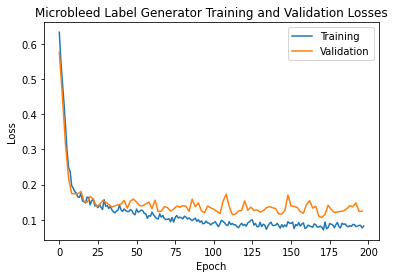

In [60]:
display_losses(checkpoint, title='Microbleed Label Generator Training and Validation Losses', combine_train_val=True)

In [61]:
print(f"Training Loss: {round(float(checkpoint[CheckpointDict.LOSSES][list(checkpoint[CheckpointDict.LOSSES])[-1]]), 4)}")
print(f"Validation Loss: {round(float(checkpoint[CheckpointDict.VALIDATION_LOSSES][list(checkpoint[CheckpointDict.VALIDATION_LOSSES])[-1]]), 4)}")

Training Loss: 0.082
Validation Loss: 0.1245


### Sample Inference

torch.Size([1, 2, 16, 16, 16])
torch.Size([2, 16, 16, 16])
inference input shape : torch.Size([1, 2, 16, 16, 16])


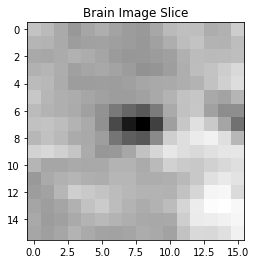

In [84]:
inference_model = model
inference_model.load_state_dict(checkpoint[CheckpointDict.MODEL_STATE_DICT])

validation_single_set = val_ds[0][0]
# print(f"Subject_id: {validation_single_set[DataDict.ID]}")
# print(validation_single_set)
inference_input = validation_single_set[DataDict.Image].unsqueeze(0).to(DEVICE)
inference_label = validation_single_set[DataDict.Label]


print(inference_input.shape)
print(inference_label.shape)

# Validation inference
print(f"inference input shape : {inference_input.shape}")
inference_output = inference_model(inference_input)
inference_output = torch.where(inference_output > 0.5, 1, 0)
inference_output.shape

plt.title("Brain Image Slice")
plt.imshow(tensor_to_cpu(inference_input[0, 0, int(PATCH_SIZE[0]/2), ...]), cmap='gray')

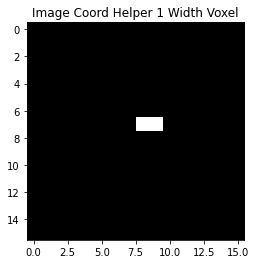

In [92]:
plt.title("Image Coord Helper 1 Width Voxel")
plt.imshow(tensor_to_cpu(inference_input[0, 1, int(PATCH_SIZE[0]/2), ...]), cmap='gray')

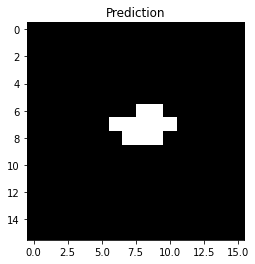

In [86]:
plt.title("Prediction")
plt.imshow(tensor_to_cpu(inference_output[0, 1, int(PATCH_SIZE[0]/2), ...]), cmap='gray')

In [87]:
inference_output[0, 1, int(PATCH_SIZE[0]/2), int(PATCH_SIZE[0]/2)-3:int(PATCH_SIZE[0]/2)+3, int(PATCH_SIZE[0]/2)-3:int(PATCH_SIZE[0]/2)+3]

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0],
        [0, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], device='cuda:0')

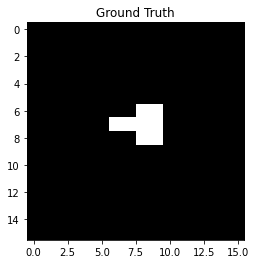

In [88]:
plt.title("Ground Truth")
plt.imshow(tensor_to_cpu(inference_label[1, int(PATCH_SIZE[0]/2), ...]), cmap='gray')

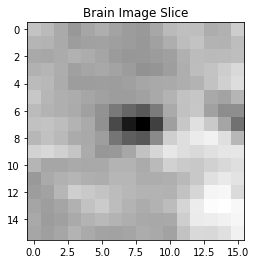

In [89]:
plt.title("Brain Image Slice")
plt.imshow(tensor_to_cpu(inference_input[0, 0, int(PATCH_SIZE[0]/2), ...]), cmap='gray')

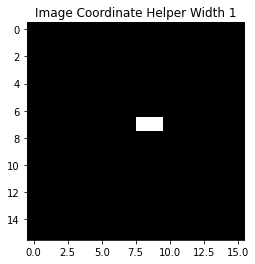

In [91]:
plt.title("Image Coordinate Helper Width 1")
plt.imshow(tensor_to_cpu(inference_input[0, 1, int(PATCH_SIZE[0]/2), ...]), cmap='gray')

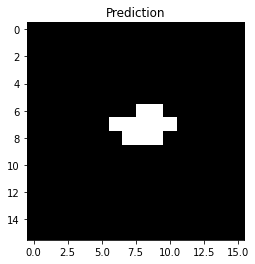

In [90]:
plt.title("Prediction")
plt.imshow(tensor_to_cpu(inference_output[0, 1, int(PATCH_SIZE[0]/2), ...]), cmap='gray')

In [69]:
inference_output[0, 1, int(PATCH_SIZE[0]/2), int(PATCH_SIZE[0]/2)-5:int(PATCH_SIZE[0]/2)+5, int(PATCH_SIZE[0]/2)-5:int(PATCH_SIZE[0]/2)+5]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')

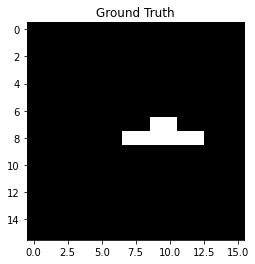

In [70]:
plt.title("Ground Truth")
plt.imshow(tensor_to_cpu(inference_label[1, int(PATCH_SIZE[0]/2), ...]), cmap='gray')

## Label Generator

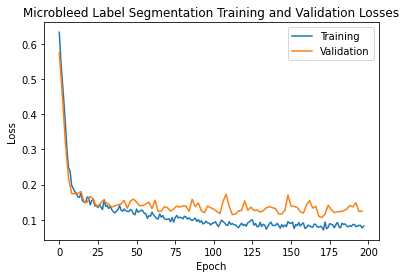

In [71]:
# Load checkpoint
checkpoint = torch.load(f"{TRAINED_NETWORK_DIR}/{checkpoint_name}.pt")

# Instantiate model and load state dictionary
inference_model = model 
inference_model.load_state_dict(checkpoint[CheckpointDict.MODEL_STATE_DICT])

# Visualise losses 
display_losses(checkpoint, title='Microbleed Label Segmentation Training and Validation Losses', combine_train_val=True)

In [72]:
# # Declare test transforms
# test_transforms = Compose(
#     [
#         LoadImaged(keys=[DataDict.Image]),
#         AddChanneld(keys=[DataDict.Image]),
#         NormalizeIntensityd(keys=[DataDict.Image]),
#         ToTensord(keys=[DataDict.Image]),
#     ]
# )
test_transforms = Compose(
    [
        LoadImaged(keys=[DataDict.Image, DataDict.ImageHelper]),
        AddChanneld(keys=[DataDict.Image, DataDict.ImageHelper]),
        # Spacingd(keys=[DataDict.Image, DataDict.ImageHelper], pixdim=(
        #     1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        # Orientationd(keys=[DataDict.Image, DataDict.ImageHelper], axcodes="RAS"),
        NormalizeIntensityd(keys=[DataDict.Image]),
        ToTensord(keys=[DataDict.Image, DataDict.ImageHelper]),
        ImagesToMultiChannel(keys=[DataDict.Image, DataDict.ImageHelper])
    ]
)

In [73]:
# Manual Crop handler
CROP_WIDTH = PATCH_SIZE[0]

# From a whole brain image get desired patch by centre coord
def get_patch_image(image, coord, width=CROP_WIDTH, list_axis_errors=None):
    # Coordinates start from 1, but tensor start from 0
    x = coord[0]-1
    y = coord[1]-1
    z = coord[2]-1
    half_width = int(width/2)

    require_padding = False

    x_shape_ind = 1
    y_shape_ind = 2
    z_shape_ind = 3
    
    # Hardcoded method where patch size sample beyong image boundaries, padded if beyond
    if list_axis_errors is not None:
        # Check x is within lower bound ()
        if x < (half_width + 1):
            print(f"X lower bound error:{image.shape}\t {coord}")
            list_axis_errors[AxisErrorType.XLower] = list_axis_errors[AxisErrorType.XLower] + 1
            require_padding = True

        # Check x is within upper bound
        if (x + (half_width)) > image[0].shape[0]:
            print(f"X upper bound error:{image[0].shape}\t {coord}")
            list_axis_errors[AxisErrorType.XUpper] = list_axis_errors[AxisErrorType.XUpper] + 1
            require_padding = True
        
        # Check x is within lower bound ()
        if y < (half_width + 1):
            print(f"Y lower bound error:{image[0].shape}\t {coord}")
            list_axis_errors[AxisErrorType.YLower] = list_axis_errors[AxisErrorType.YLower] + 1
            require_padding = True

        # Check x is within upper bound
        if (y + (half_width)) > image[0].shape[1]:
            print(f"Y upper bound error:{image[0].shape}\t {coord}") 
            list_axis_errors[AxisErrorType.YUpper] = list_axis_errors[AxisErrorType.YUpper] + 1
            require_padding = True

        # Check x is within lower bound ()
        if z < (half_width + 1):
            print(f"Z lower bound error:{image[0].shape}\t {coord}")
            list_axis_errors[AxisErrorType.ZLower] = list_axis_errors[AxisErrorType.ZLower] + 1
            require_padding = True

        # Check x is within upper bound
        # print(f"coord is {coord}, z shape : {image[0].shape[2]}, normal shape: {image.shape}")
        if (z + (half_width)) > image[0].shape[2]:
            print(f"Z upper bound error:{image[0].shape}\t {coord}")
            list_axis_errors[AxisErrorType.ZUpper] = list_axis_errors[AxisErrorType.ZUpper] + 1
            require_padding = True

    if require_padding:
        # Start
        padded_image = torch.zeros((2, image.shape[x_shape_ind] + width, image.shape[y_shape_ind] + width, image.shape[z_shape_ind] + width))
        print(f"Shape from {image.shape} to {padded_image.shape}")

        padded_image[0, half_width:image.shape[x_shape_ind]+half_width, half_width:image.shape[y_shape_ind]+half_width, half_width:image.shape[z_shape_ind]+half_width] = image[0]
        padded_image[1, half_width:image.shape[x_shape_ind]+half_width, half_width:image.shape[y_shape_ind]+half_width, half_width:image.shape[z_shape_ind]+half_width] = image[1]

        patch_image = padded_image[:, x:x+(2*half_width), y:y+(2*half_width), z:z+(2*half_width)]
    else:
        patch_image = image[:, x-half_width:x+half_width, y-half_width:y+half_width, z-half_width:z+half_width]

    return patch_image, require_padding, list_axis_errors

# Insert patch into a volume image
def replace_patch(image, replace_patch, coord, width=CROP_WIDTH, is_patch_image_padded=False):
    # Coordinates start from 1, but tensor start from 0
    x = coord[0]-1
    y = coord[1]-1
    z = coord[2]-1
    half_width = int(width/2)

    if is_patch_image_padded:
        # Exclude z axis padding
        image_temp = torch.zeros((image.shape[0] + width, image.shape[1] + width, image.shape[2] + width))
        print(f"Replace patch require padding: Shape from {image.shape} to {image_temp.shape}")

        # Replace patch with the offset
        # print(f"image temp :{image_temp.shape}. patch{replace_patch.shape}")
        image_temp[x:x+(2*half_width), y:y+(2*half_width),  z:z+(2*half_width)] = replace_patch

        image = image_temp[half_width:image.shape[0]+half_width, half_width:image.shape[1]+half_width, half_width:image.shape[2]+half_width]
    else:
        image[x-half_width:x+half_width, y-half_width:y+half_width, z-half_width:z+half_width] = replace_patch

    return image


def get_coord_dicts(dataframe, data_paths, filename_column="NIFTI File Name", microbleeds_per_subj=27):
    """
      dataframe: dataframe containining column with filename and columns specifying coordinates for each microbleed
    """
    list_data_dict = []

    for data_path in data_paths:
        target_df_row = dataframe.loc[dataframe['NIFTI File Name'] == data_path[DataDict.FileName]]
        
        for i in range(microbleeds_per_subj):
            x = target_df_row.iloc[0][f'{i+1}-1']
            y = target_df_row.iloc[0][f'{i+1}-2']
            z = target_df_row.iloc[0][f'{i+1}-3']

            if isinstance(x, str) or isinstance(y, str) or isinstance(z, str):
                continue

            filename = data_path[DataDict.FileName]
            # Get subject Id, T and V numbers to match exact file
            # E.g. "3_T2_MRI_SWI_BFC_50mm_HM_rsCMB_V1.nii.gz"
            subject_id = int(filename.split('_')[0])
            t_number = int(filename.split('_')[1].replace('T', ''))
            v_number = int(filename.split('_')[-1].replace('.nii.gz', '').replace('V', ''))

            # print(filename, subject_id, t_number, v_number)

            microbleed_detecting_helper_image = os.path.join(image_coordinate_guider_dir, f"{subject_id}_T{t_number}_V{v_number}/fake_label_{filename}")

            dict_to_append = {DataDict.FileName: data_path[DataDict.FileName], 
                              DataDict.Image: data_path[DataDict.Image], 
                              DataDict.ImageHelper: microbleed_detecting_helper_image,
                              DataDict.ID: subject_id,
                              DataDict.VersionId: v_number,
                              DataDict.ScanTimeVersion: t_number,
                              DataDict.X: target_df_row.iloc[0][f'{i+1}-1'],
                              DataDict.Y: target_df_row.iloc[0][f'{i+1}-2'],
                              DataDict.Z: target_df_row.iloc[0][f'{i+1}-3']}

            list_data_dict.append(dict_to_append)

    return list_data_dict

In [74]:
# Synthetic microbleed training data
test_data_path = f"/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/"

# Exclude manually annotated images
to_exclude = [subject[DataDict.FileName] for subject in train_data_paths]
to_exclude

test_data_paths = []

# Append list dict of training data into a list
for index, row in coordinate_info_df.iterrows():
    if row['NIFTI File Name'] not in to_exclude:
        filename = row['NIFTI File Name']
        image = test_data_path + row['NIFTI File Name']

        test_data_paths.append({DataDict.FileName: filename, DataDict.Image: image})

# test_data_path

In [75]:
included_filenames = [item[DataDict.FileName] for item in test_data_paths]

In [76]:
# List dicts per microbleed containing file path and microbleed coordinates
test_data_dicts = get_coord_dicts(coordinate_info_df, test_data_paths)

In [77]:
test_data_dicts

[{'filename': '122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V1.nii.gz',
  'id': 122,
  'image': '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V1.nii.gz',
  'image_helper': '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/GeneratedLabels/FakeGeneratedLabels/122_T1_V1/fake_label_122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V1.nii.gz',
  'scan_time_version': 1,
  'version_id': 1,
  'x': 103,
  'y': 64,
  'z': 46},
 {'filename': '122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V1.nii.gz',
  'id': 122,
  'image': '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V1.nii.gz',
  'image_helper': '/content/drive/MyDrive/Brain Health In COV

In [79]:
# Final Inference code
generate_labels = False

patch_16 = True # False if evaluating patch 32
setup2 = False
patch_subdirectory = ("Patch16_Setup2" if setup2 else "Patch16") if patch_16 else "Patch32"
print(patch_subdirectory)
# target_output_folder = f"/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/EPAD_WMD/SyntheticCMBPaperData/webdav-bm.data.csiro.au/dap_prd_000050304v001/PublicDataShare_2020/sCMB_DefiniteSubject/PredictedLabels/{patch_subdirectory}/"
target_output_folder = f"/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/GeneratedLabels/PredictedLabels_2Channels_1widthdetector/"

patch_error_filenames = []

if os.path.exists(target_output_folder) == False:
    os.mkdir(target_output_folder)

class AxisErrorType():
    XLower = "x_lower"
    XUpper = "x_upper"
    YLower = "y_lower"
    YUpper = "y_upper"
    ZLower = "z_lower"
    ZUpper = "z_upper"

list_axis_errors = { AxisErrorType.XLower: 0, AxisErrorType.XUpper: 0, 
                    AxisErrorType.YLower: 0, AxisErrorType.YUpper: 0,
                    AxisErrorType.ZLower: 0, AxisErrorType.ZUpper: 0,
                    }

if generate_labels: 
    # Iterate over all inluded filenames and infer
    for filename_idx, included_filename in enumerate(included_filenames):
        print(f"Analysing subject {filename_idx+1}/{len(included_filenames)}")
        same_subject_microbleeds_dict = get_dicts_from_dicts(test_data_dicts, DataDict.FileName, included_filename)

        # Fileimage path should be the same so get first
        nibabel_file = nb.load(same_subject_microbleeds_dict[0][DataDict.Image])
        swi_image = nibabel_file.get_fdata()

        # Initialise data
        current_dataset = Dataset(data=[same_subject_microbleeds_dict[0]], transform=test_transforms)
        current_data_loader = DataLoader(current_dataset, batch_size=1, num_workers=0)

        # Initialise image and label template
        current_data = next(iter(current_data_loader))
        current_subject_image = current_data[DataDict.Image].squeeze_().squeeze_()

        print(f"swi_image is: {swi_image.shape}, current image is {current_subject_image.shape}")

        # Get Subject Id
        subject_id = int(current_data[DataDict.ID])
        version_id = int(current_data[DataDict.VersionId])
        scan_time_version_id = int(current_data[DataDict.ScanTimeVersion])

        # test_labels_dict created per microbleed to prevent patch overlap issues
        # test_label = torch.zeros_like(torch.tensor(swi_image))
        test_label = torch.zeros_like(torch.tensor(swi_image))
        test_labels_dict = {}
        test_labels_dict

        for idx in range(len(same_subject_microbleeds_dict)):
            test_labels_dict[idx] = test_label
        
        # Iterate over dictionary to infer mirobleed
        for idx, microbleed_dict in enumerate(same_subject_microbleeds_dict):
            microbleed_coord = (microbleed_dict[DataDict.X], microbleed_dict[DataDict.Y], microbleed_dict[DataDict.Z])
        
            # Obtain patch image by coordinate with microbleed in centre
            patch_image, is_patch_image_padded, list_axis_errors = get_patch_image(current_subject_image, microbleed_coord, CROP_WIDTH, list_axis_errors)     
            
            if patch_image.shape != torch.Size([2, int(PATCH_SIZE[0]), int(PATCH_SIZE[1]), int(PATCH_SIZE[2])]):
                print(f"Error in patch {patch_image.shape}\tImage_size:{current_subject_image.shape}\tCoord:{microbleed_coord}\tFilename_idx:{filename_idx}\tMicrobleed_Idx:{idx}.")
                patch_error_filenames.append(microbleed_dict[DataDict.FileName])
                continue

            # print(f"patch image is {patch_image.shape}")
            # patch_image = patch_image.unsqueeze(0).unsqueeze(0).to(DEVICE)
            patch_image = patch_image.unsqueeze(0).to(DEVICE)
            # print(f"patch image is {patch_image.shape}")
            output_patch = inference_model(patch_image)
            # print(f"output_patch image is {output_patch.shape}")

            output_patch = torch.where(output_patch > 0.5, 1, 0)

            test_labels_dict[idx] = replace_patch(test_label, tensor_to_cpu(output_patch[0, 1, ...]), microbleed_coord, is_patch_image_padded=is_patch_image_padded)

        # Combine all patches into one
        for key, val in test_labels_dict.items():
            test_label += val

        # Convert all values in tensor to 1 if above zero
        test_label = torch.where(test_label > 0, 1, 0)

        # print(f"Filename is {included_filename} and affine properties: {nibabel_file.affine}")
        numpy_output = np.array(test_label)
        # Must be converted as numpy.single due to formatting issues
        numpy_output = numpy_output.astype(np.single)

        # Keep and match affine transformation to original image
        nb_image_to_save = nb.Nifti1Image(numpy_output, nibabel_file.affine)
        # nb_image_to_save = nb.Nifti1Image(numpy_output, np.eye(4))
        
        subject_dir_path = os.path.join(target_output_folder, f'{subject_id}_T{scan_time_version_id}_V{version_id}/')

        if os.path.exists(subject_dir_path) == False:
            os.mkdir(subject_dir_path)

        # Save Nib file to target location
        nb.save(nb_image_to_save, f'{subject_dir_path}/seg_out_{included_filename}')
        # nb.save(nb_image_to_save, f'{target_output_folder}{included_filename.replace(".nii.gz", "_Label.nii.gz")}')
        print("\n")
    
print("DONE")

Patch16
Analysing subject 1/560
swi_image is: (176, 256, 80), current image is torch.Size([2, 176, 256, 80])


Analysing subject 2/560
swi_image is: (176, 256, 80), current image is torch.Size([2, 176, 256, 80])


Analysing subject 3/560
swi_image is: (176, 256, 80), current image is torch.Size([2, 176, 256, 80])


Analysing subject 4/560
swi_image is: (176, 256, 80), current image is torch.Size([2, 176, 256, 80])
Z lower bound error:torch.Size([176, 256, 80])	 (127, 175, 8)
Shape from torch.Size([2, 176, 256, 80]) to torch.Size([2, 192, 272, 96])
Replace patch require padding: Shape from torch.Size([176, 256, 80]) to torch.Size([192, 272, 96])


Analysing subject 5/560
swi_image is: (176, 256, 80), current image is torch.Size([2, 176, 256, 80])


Analysing subject 6/560
swi_image is: (176, 256, 80), current image is torch.Size([2, 176, 256, 80])


Analysing subject 7/560
swi_image is: (176, 256, 80), current image is torch.Size([2, 176, 256, 80])


Analysing subject 8/560
swi_image is

In [ ]:
image_test = current_data[DataDict.Image]

x, y, z = 125, 134, 44

width = 20

image_test.shape

In [ ]:
print(microbleed_dict)
print(microbleed_dict[DataDict.X], microbleed_dict[DataDict.Y], microbleed_dict[DataDict.Z])

In [ ]:
plt.imshow(tensor_to_cpu(image_test[0, x-width:x+width, y-width:y+width, z]), cmap='gray')

In [ ]:
plt.imshow(tensor_to_cpu(image_test[1, x-width:x+width, y-width:y+width, z]), cmap='gray')

In [ ]:
# patch_image = image[:, x-half_width:x+half_width, y-half_width:y+half_width, z-half_width:z+half_width]

In [ ]:
plt.imshow(tensor_to_cpu(patch_image[0, 0, ..., 8]), cmap='gray')


# patch_image = patch_image.unsqueeze(0).to(DEVICE)
# # print(f"patch image is {patch_image.shape}")
# output_patch = inference_model(patch_image)

In [ ]:
plt.imshow(tensor_to_cpu(patch_image[0, 1, ..., 8]), cmap='gray')

In [ ]:
plt.imshow(tensor_to_cpu(output_patch[0, 1, ..., 8]), cmap='gray')

In [ ]:
predicted_directories = glob.glob(f"{target_output_folder}/*/")
len(predicted_directories) # should be same as analysed i.e 560

## Label Generated Evaluation - Againest Fake Hard Coded Labels

In [80]:

import EvalCMBSeg as evalcmb

In [81]:
evalcmb

<module 'EvalCMBSeg' from '/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/src/EvalCMBSeg.py'>

In [83]:
# from EvalCMBSeg import *


# evalcmb.segoutPath = f"/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/GeneratedLabels/PredictedLabels/"
# evalcmb.labelPath= "/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/GeneratedLabels/FakeGeneratedLabels/"

evalcmb.segoutPath = target_output_folder
evalcmb.labelPath = "/content/drive/MyDrive/Brain Health In COVID 19/Microbleed_Segmentation/Microbleed_Segmentation/GeneratedLabels/FakeGeneratedLabels_3Width/"

evalcmb.labelPrefix = "fake_label_"
evalcmb.imagePrefix = "seg_out_"

results =  evalcmb.get_metrics(using_folds=True)        

print(results)

Image 122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V8.nii.gz statistics:
True positives: 12 
False positives: 4
False negatives:  0
Predicted number of microbleeds: 16 
Actual number of microbleeds: 12
Image 122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V7.nii.gz statistics:
True positives: 12 
False positives: 2
False negatives:  0
Predicted number of microbleeds: 14 
Actual number of microbleeds: 12
Image 122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V6.nii.gz statistics:
True positives: 12 
False positives: 0
False negatives:  0
Predicted number of microbleeds: 12 
Actual number of microbleeds: 12
Image 122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V5.nii.gz statistics:
True positives: 11 
False positives: 3
False negatives:  1
Predicted number of microbleeds: 14 
Actual number of microbleeds: 12
Image 122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V4.nii.gz statistics:
True positives: 10 
False positives: 3
False negatives:  1
Predicted number of microbleeds: 13 
Actual number of microbleeds: 11
Image 122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V3.nii.gz s

In [ ]:
results

## Testing sucessful predictions (False Negatives) _ Basic TEST


In [ ]:
len(test_data_dicts)

In [ ]:
test_tensor = torch.tensor([[0, 0, 1], [0, 0, 0]])
test_tensor2 = torch.tensor([[0, 0, 0], [0, 0, 0]])
print(1 in test_tensor, 1 in test_tensor2)

In [ ]:
predicted_labels_list = glob.glob(f"{target_output_folder}*.nii.gz")
# predicted_labels_list = os.listdir(target_output_folder)
os.path.basename(predicted_labels_list[0])

In [ ]:
# predicted_labels_list = glob.glob(f"{target_output_folder}*.nii.gz")
predicted_labels_list = os.listdir(target_output_folder)
predicted_labels_list[1]

In [ ]:
# Get list of predicted labels
predicted_labels_list = glob.glob(f"{target_output_folder}*.nii.gz")
# predicted_labels_list = os.listdir(target_output_folder)
# predicted_labels_list_dicts = [{DataDict.FileName: predicted_label_list, DataDict.Label: os.path.join(target_output_folder, predicted_label_list)} for predicted_label_list in predicted_labels_list]
predicted_labels_list_dicts = [{DataDict.FileName: os.path.basename(predicted_label_list), DataDict.Label: predicted_label_list} for predicted_label_list in predicted_labels_list]
correct_prection_list = []
incorrect_microbleed_dict_list = []

target_file_check = None

# Iterate through each file
for image_idx, predicted_label_list_dicts in enumerate(predicted_labels_list_dicts):
    brain_image_filename = predicted_label_list_dicts[DataDict.FileName].replace("_Label", "")
    label_filename = predicted_label_list_dicts[DataDict.FileName]
    
    # Load coordinate systems for current filename
    current_image_microbleeds_dicts = get_dicts_from_dicts(test_data_dicts, DataDict.FileName, brain_image_filename)

    # Append dict properties together
    for current_image_microbleed_dict in current_image_microbleeds_dicts:
        current_image_microbleed_dict[DataDict.Label] = predicted_label_list_dicts[DataDict.Label]

    prediction_correct = 0

    # For each microbleed check if coordinate is more than zero
    for microbleed_idx, microbleed_dict in enumerate(current_image_microbleeds_dicts):
        x = microbleed_dict[DataDict.X]
        y = microbleed_dict[DataDict.Y]
        z = microbleed_dict[DataDict.Z]
        
        # Load predicted label
        label_image = nb.load(microbleed_dict[DataDict.Label]).get_fdata()

        # correct_microbleed_prediction = label_image[x, y, z] > 0
        # Give a +- 2 pixel leeway 
        boundary_slack = 3
        correct_microbleed_prediction = 1 in label_image[x-boundary_slack:x+boundary_slack, y-boundary_slack:y+boundary_slack, z-boundary_slack:z+boundary_slack]

        if correct_microbleed_prediction:
            prediction_correct += 1
        else:
            incorrect_microbleed_dict_list.append({DataDict.FileName: label_filename, "Coordinates": (x, y, z)})
        
    print(f"{image_idx}/{len(predicted_labels_list_dicts)} subject: {prediction_correct}/{len(current_image_microbleeds_dicts)} correctly predicted")
    # correct_prection_list[f"Subject-{image_idx}"] = {"Correct_Predictions": prediction_correct, DataDict.Filename: label_filename}
    correct_prection_list.append({"Correct_Predictions": prediction_correct, DataDict.FileName: label_filename, "Total_Micrbleeds": len(current_image_microbleeds_dicts)})

# current_image_microbleeds_dicts
correct_prection_list

In [ ]:
incorrect_total = 0
total_microbleeds = 0

for correct_prection_list_item in correct_prection_list:
    incorrect_cur = correct_prection_list_item['Total_Micrbleeds']- correct_prection_list_item["Correct_Predictions"]
    incorrect_total += incorrect_cur
    total_microbleeds += correct_prection_list_item['Total_Micrbleeds']

#CHECK THIS

total_microbleeds = len(test_data_dicts)
print(f"Incorrect Total: {incorrect_total}\tMicrobleed Total: {total_microbleeds}\tPercentage Correct: {round((total_microbleeds-incorrect_total)/total_microbleeds*100, 2)}%")

In [ ]:
incorrect_microbleed_dict_list
with open(os.path.join(target_output_folder, 'incorrect_microbleed_dict_list.txt'), 'w') as f:
    f.write(str(incorrect_microbleed_dict_list))

In [ ]:
predicted_labels_list_dicts

In [ ]:
test_load = nb.load(f"{target_output_folder}122_T1_MRI_SWI_BFC_50mm_HM_rsCMB_V2_Label.nii.gz")
test_image = test_load.get_fdata()
print(test_image.shape)
# 140, 116, 28
#118, 196, 31
coord = (118, 196, 31)
x = coord[0]
y = coord[1]
z = coord[2]
plt.imshow(test_image[x-20:x+20, y-20:y+20, z], cmap='gray')

plt.imshow(test_image[..., z], cmap='gray')

In [ ]:
coordinates_test_1 = [(item[DataDict.X], item[DataDict.Y], item[DataDict.Z]) for item in same_subject_microbleeds_dict]
coordinates_test_1

In [ ]:
coord_sample = coordinates_test_1[2]
x = coord_sample[0]
y = coord_sample[1]
z = coord_sample[2]

plt.imshow(tensor_to_cpu(test_label[x-30:x+30, y-30:y+30, z]), cmap="gray")

TO DO: 
- Retrain network as 4.pt
- Get all predicted labels
- Compare against coordinates to find coordinates with center pixel != 1
- manually annotate non annotated microbleeds
- train all data on network. 

In [ ]:
list_axis_errors

In [ ]:
len(patch_error_filenames)

In [ ]:
# patch_error_filenames_unique = [item for item in patch_error_filenames if item ]
patch_error_filenames_unique = np.array(patch_error_filenames)
patch_error_filenames_unique = np.unique(patch_error_filenames_unique)
patch_error_filenames_unique = list(patch_error_filenames_unique)
len(patch_error_filenames_unique)

In [ ]:
os.cwd()